# Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import missingno as msno
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import pickle
import tweepy
warnings.filterwarnings("ignore")
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Loading the data

In [2]:
df = pd.read_csv('movie_review.csv')

In [3]:
df.head(20)

,fold_id,cv_tag,html_id,sent_id,text,tag
0,0,cv000,29590,0,films adapted from comic books have had plenty...,pos
1,0,cv000,29590,1,"for starters , it was created by alan moore ( ...",pos
2,0,cv000,29590,2,to say moore and campbell thoroughly researche...,pos
3,0,cv000,29590,3,"the book ( or "" graphic novel , "" if you will ...",pos
4,0,cv000,29590,4,"in other words , don't dismiss this film becau...",pos
5,0,cv000,29590,5,if you can get past the whole comic book thing...,pos
6,0,cv000,29590,6,getting the hughes brothers to direct this see...,pos
7,0,cv000,29590,7,"the ghetto in question is , of course , whitec...",pos
8,0,cv000,29590,8,"it's a filthy , sooty place where the whores (...",pos
9,0,cv000,29590,9,"when the first stiff turns up , copper peter g...",pos


In [4]:
df.shape

(64720, 6)

# Data preprocessing and cleaning

## Dropping irrelevant columns

In [5]:
df = df.drop(columns=['fold_id','cv_tag','html_id','sent_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64720 entries, 0 to 64719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    64720 non-null  object
 1   tag     64720 non-null  object
dtypes: object(2)
memory usage: 1011.4+ KB


## Displaying some reviews of both classes

In [6]:
positive_reviews = df[df['tag'] == 'pos']
negative_reviews = df[df['tag'] == 'neg']

### Showing positive reviews

In [7]:
for i in range (15):
  print(f"Review no:{i+1}\n{positive_reviews['text'].iloc[i]}")
  print("\n")

Review no:1
films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before .


Review no:2
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen .


Review no:3
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd .


Review no:4
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes .


Review no:5
in other words , don't dismiss this film because of its source .


Review no:6
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert an

### Showing negative reviews

In [8]:
for i in range (15):
  print(f"Review no:{i+1}\n{negative_reviews['text'].iloc[i]}")
  print("\n")

Review no:1
plot : two teen couples go to a church party , drink and then drive .


Review no:2
they get into an accident .


Review no:3
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares .


Review no:4
what's the deal ?


Review no:5
watch the movie and " sorta " find out . . .


Review no:6
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package .


Review no:7
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly .


Review no:8
they seem to have taken this pretty neat concept , but executed it terribly .


Review no:9
so what are the problems with the movie ?


Review no:10
well , its main problem is that it's simply too jum

## Checking for null values

<Axes: >

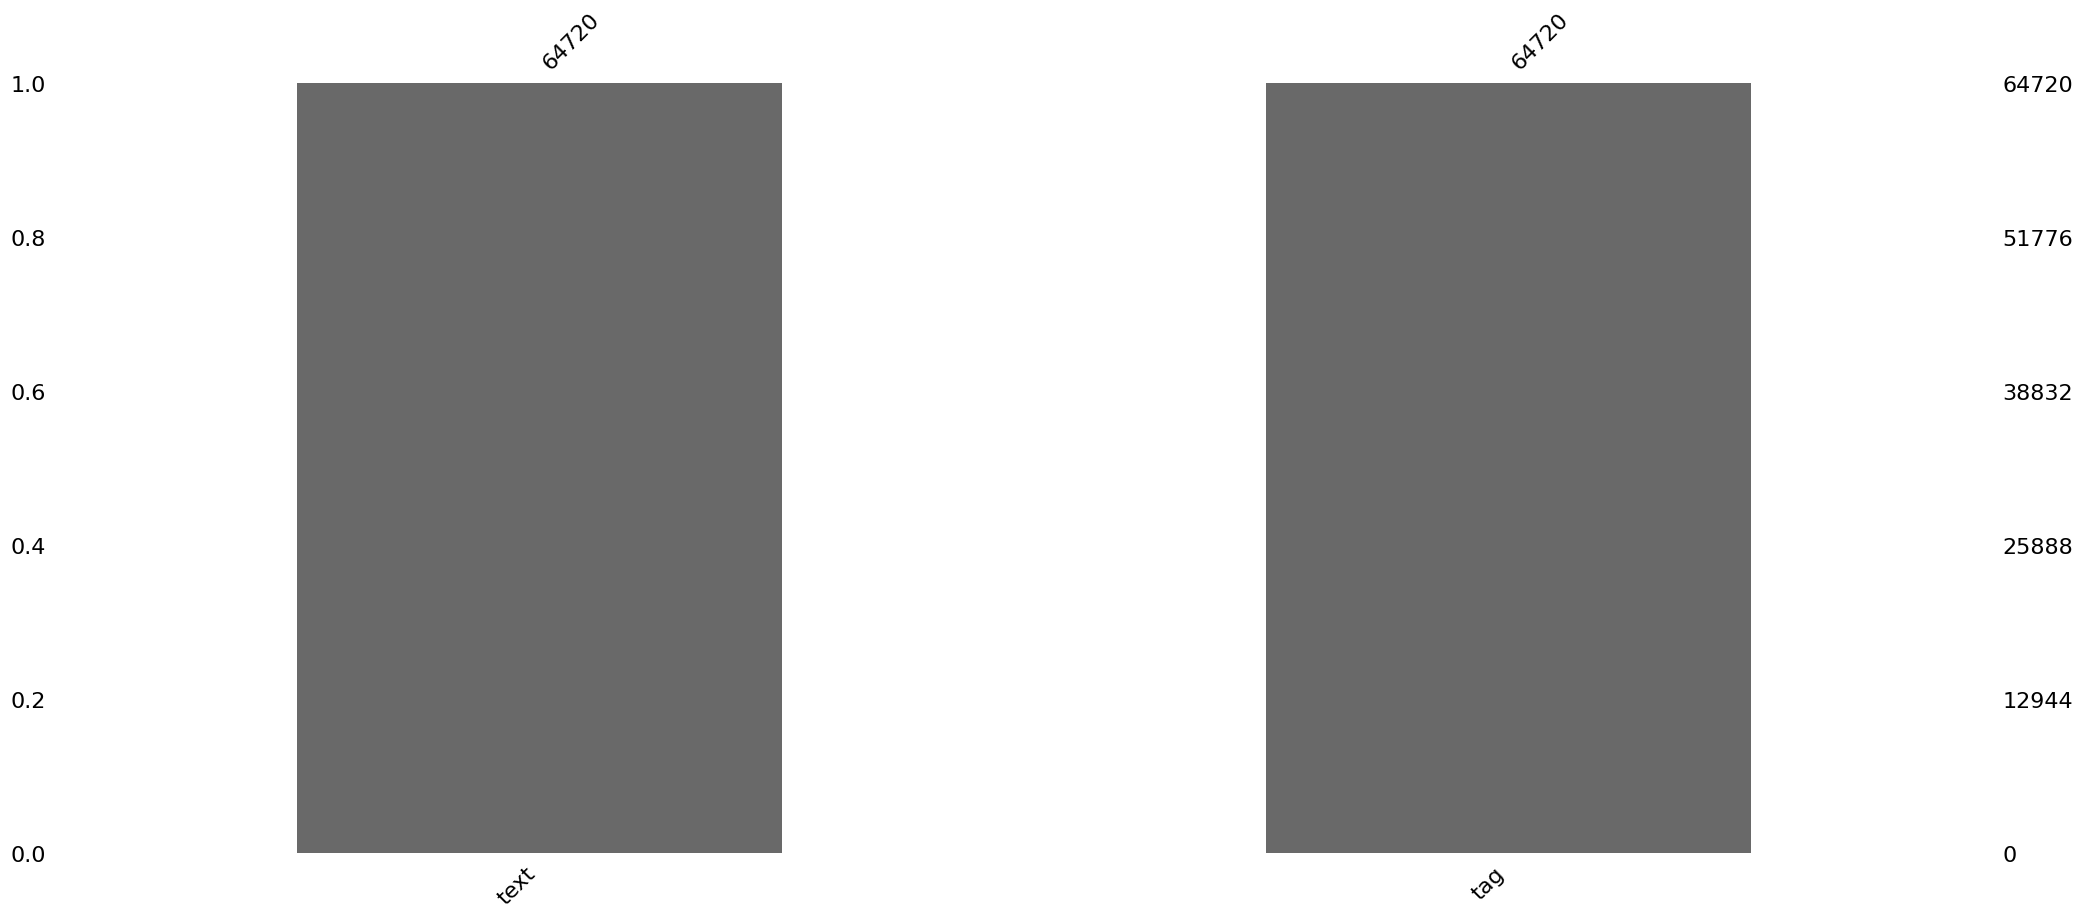

In [9]:
msno.bar(df)

*No feature has missing values*





### Dropping reviews that has empty white space values

In [10]:
blanks = []
for i,twt,lb in df.itertuples():
  if type(twt) == str:
    if twt.isspace():
      blanks.append(i)


In [11]:
df.drop(blanks,inplace=True)

In [12]:
df.shape

(64720, 2)

*No such empty white spaces found*

## Check for class imbalance

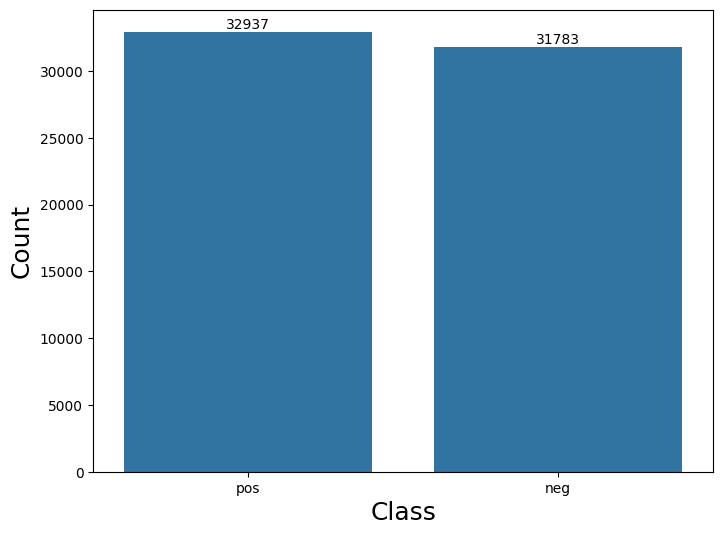

In [13]:
class_count = df['tag'].value_counts()
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_count.index, y=class_count)
plt.xlabel('Class', fontsize=18)
plt.ylabel('Count', fontsize=18)

# Add count labels to the bars
for p in ax.patches:
    count = int(p.get_height())  # Convert the count to integer
    ax.annotate(f"{count}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')

plt.show()

*Data is almost balanced*

## Data cleaning

In [14]:
def clean_text(sentence):
    # Lowercase the text
    sentence = sentence.lower()

    # Remove special characters
    sentence = re.sub(r"[^\w\s]", "", sentence)

    # Remove punctuation
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    sentence = re.sub(r"\d+", "", sentence)

    # Remove HTML tags
    sentence = BeautifulSoup(sentence, "html.parser").get_text()

    # Remove URLs
    sentence = re.sub(r"http\S+|www\S+|https\S+", "", sentence)

    # Remove whitespace
    sentence = re.sub(r"\s+", " ", sentence).strip()

    # Tokenize the sentence
    tokens = word_tokenize(sentence)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Perform stemming
    lemmatizer = WordNetLemmatizer()
    lemmatised = [lemmatizer.lemmatize(i) for i in filtered_tokens]

    cleaned_sentence = " ".join(lemmatised)

    return cleaned_sentence

### Showing some positve reviews after transformation

In [15]:
positive_reviews['text'] = positive_reviews['text'].apply(lambda x : clean_text(x))
for i in range (15):
  print(f"Review no:{i+1}\n{positive_reviews['text'].iloc[i]}")
  print("\n")

Review no:1
film adapted comic book plenty success whether theyre superheroes batman superman spawn geared toward kid casper arthouse crowd ghost world there never really comic book like hell


Review no:2
starter created alan moore eddie campbell brought medium whole new level mid part series called watchman


Review no:3
say moore campbell thoroughly researched subject jack ripper would like saying michael jackson starting look little odd


Review no:4
book graphic novel page long includes nearly consist nothing footnote


Review no:5
word dont dismiss film source


Review no:6
get past whole comic book thing might find another stumbling block hell director albert allen hughes


Review no:7
getting hughes brother direct seems almost ludicrous casting carrot top well anything riddle better direct film thats set ghetto feature really violent street crime mad genius behind menace ii society


Review no:8
ghetto question course whitechapel london east end


Review no:9
filthy sooty place

### Showing some negative reviews after transformation

In [16]:
negative_reviews['text'] = negative_reviews['text'].apply(lambda x : clean_text(x))
for i in range (15):
  print(f"Review no:{i+1}\n{negative_reviews['text'].iloc[i]}")
  print("\n")

Review no:1
plot two teen couple go church party drink drive


Review no:2
get accident


Review no:3
one guy dy girlfriend continues see life nightmare


Review no:4
whats deal


Review no:5
watch movie sorta find


Review no:6
critique mindfuck movie teen generation touch cool idea present bad package


Review no:7
make review even harder one write since generally applaud film attempt break mold mess head lost highway memento good bad way making type film folk didnt snag one correctly


Review no:8
seem taken pretty neat concept executed terribly


Review no:9
problem movie


Review no:10
well main problem simply jumbled


Review no:11
start normal downshift fantasy world audience member idea whats going


Review no:12
dream character coming back dead others look like dead strange apparition disappearance looooot chase scene ton weird thing happen simply explained


Review no:13
personally dont mind trying unravel film every give clue get kind fed film biggest problem


Review no:14


In [17]:
df['text'] = df['text'].apply(lambda x : clean_text(x))

## Generating word cloud of most frequent words of each class

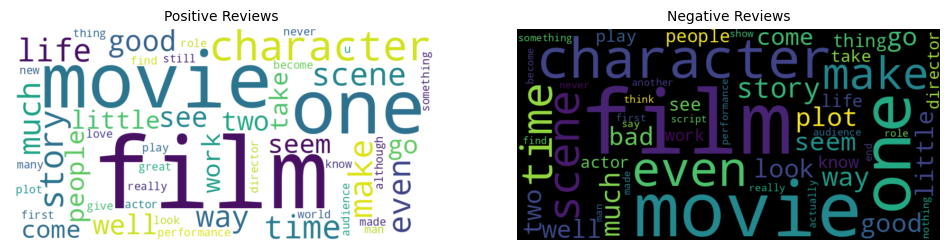

In [18]:
max_words = 50
positive_wordcloud = WordCloud(width=800, height=400,max_words=max_words,background_color ='white').generate(' '.join(positive_reviews['text']))
negative_wordcloud = WordCloud(width=800, height=400,max_words=max_words).generate(' '.join(negative_reviews['text']))


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews',fontsize = 10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews',fontsize = 10)
plt.axis('off')


plt.show()

# Model development

## Declaring Inputs & Targets variable

In [19]:
x = df["text"]
y = df["tag"]

## Splitting the data

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

## Converting text to matrix of TFIDF features

In [21]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

## Logistic Regression

In [22]:
LR = LogisticRegression(max_iter=500)
LR.fit(x_train,y_train)

LogisticRegression(max_iter=500)

In [23]:
pred_lr=LR.predict(x_test)
print(pred_lr)

['pos' 'neg' 'pos' ... 'pos' 'pos' 'neg']


# Model Evaluation

In [24]:
LR.score(x_test, y_test)
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

         neg       0.69      0.67      0.68      6371
         pos       0.69      0.71      0.70      6573

    accuracy                           0.69     12944
   macro avg       0.69      0.69      0.69     12944
weighted avg       0.69      0.69      0.69     12944



# Testing

In [25]:
def testing(Review):
  Review = vectorizer.transform([clean_text(Review)]).toarray()
  print(LR.predict(Review)[0])

In [26]:
testing('This is the worst movie of the year.')

neg


In [27]:
testing('Another masterpiece from the young talented actor')

pos
